# Faostat world regions
We collect the data about crops yields (maiye, millet and others) that will be used as predictands of our model, and of some predictors (temperature anomalies, precipitations, fertilizers). The data is provided for each of the 5 contitnents. Africa, Asia, America, Europe, Oceania. 

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import dates
import matplotlib.dates as mdates
from osgeo import gdal, osr, ogr
import geopandas as gpd
from shapely.geometry import Point
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union
import warnings
warnings.filterwarnings('ignore')
from platform import python_version
print("Python version: %s"%python_version())
print("NumPy version: %s"%np.__version__)
print("Pandas version: %s"%pd.__version__)
print('GDAL version: %s'%gdal.__version__)
print("GeoPandas version: %s"%gpd.__version__)

Python version: 3.11.5
NumPy version: 1.25.2
Pandas version: 2.1.1
GDAL version: 3.7.2
GeoPandas version: 0.14.0


## Time series
The data for predictands and predictors are available as yearly time series so we define a time index that will be used for all of them  

In [28]:
year_index = pd.date_range('1961', '2023', freq='Y')
print('Start: {}\nEnd: {}'.format(year_index[0], year_index[len(year_index) - 1]))

Start: 1961-12-31 00:00:00
End: 2022-12-31 00:00:00


## Maize yield

In [35]:
path_maize_dataset = 'data/FAOSTAT_maize_world_regions.csv'
maize_yield_world_regions_tmp_df = pd.read_csv(path_maize_dataset, usecols=['Area', 'Year', 'Value'])
maize_yield_world_regions_tmp_df.shape

(310, 3)

In [44]:
maize_yield_world_regions_tmp_df.head(2)

,Area,Year,Value
0,Africa,1961,10444
1,Africa,1962,11112


In [47]:
maize_yield_africa_tmp_df = maize_yield_world_regions_tmp_df[maize_yield_world_regions_tmp_df['Area']=='Africa']
maize_yield_africa_tmp_df.drop('Area', axis=1, inplace=True)
maize_yield_africa_tmp_df.set_index(year_index, inplace=True)
maize_yield_africa_tmp_df.drop('Year', axis=1, inplace=True)
maize_yield_africa_tmp_df.head(2)

,Value
1961-12-31,10444
1962-12-31,11112


In [48]:
maize_yield_americas_tmp_df = maize_yield_world_regions_tmp_df[maize_yield_world_regions_tmp_df['Area']=='Americas']
maize_yield_americas_tmp_df.drop('Area', axis=1, inplace=True)
maize_yield_americas_tmp_df.set_index(year_index, inplace=True)
maize_yield_americas_tmp_df.drop('Year', axis=1, inplace=True)
maize_yield_americas_tmp_df.head(2)

,Value
1961-12-31,26789
1962-12-31,27199


In [49]:
maize_yield_asia_tmp_df = maize_yield_world_regions_tmp_df[maize_yield_world_regions_tmp_df['Area']=='Asia']
maize_yield_asia_tmp_df.drop('Area', axis=1, inplace=True)
maize_yield_asia_tmp_df.set_index(year_index, inplace=True)
maize_yield_asia_tmp_df.drop('Year', axis=1, inplace=True)
maize_yield_asia_tmp_df.head(2)

,Value
1961-12-31,11369
1962-12-31,11827


In [50]:
maize_yield_europe_tmp_df = maize_yield_world_regions_tmp_df[maize_yield_world_regions_tmp_df['Area']=='Europe']
maize_yield_europe_tmp_df.drop('Area', axis=1, inplace=True)
maize_yield_europe_tmp_df.set_index(year_index, inplace=True)
maize_yield_europe_tmp_df.drop('Year', axis=1, inplace=True)
maize_yield_europe_tmp_df.head(2)

,Value
1961-12-31,21695
1962-12-31,21203


In [51]:
maize_yield_oceania_tmp_df = maize_yield_world_regions_tmp_df[maize_yield_world_regions_tmp_df['Area']=='Oceania']
maize_yield_oceania_tmp_df.drop('Area', axis=1, inplace=True)
maize_yield_oceania_tmp_df.set_index(year_index, inplace=True)
maize_yield_oceania_tmp_df.drop('Year', axis=1, inplace=True)
maize_yield_oceania_tmp_df.head(2)

,Value
1961-12-31,21532
1962-12-31,22401


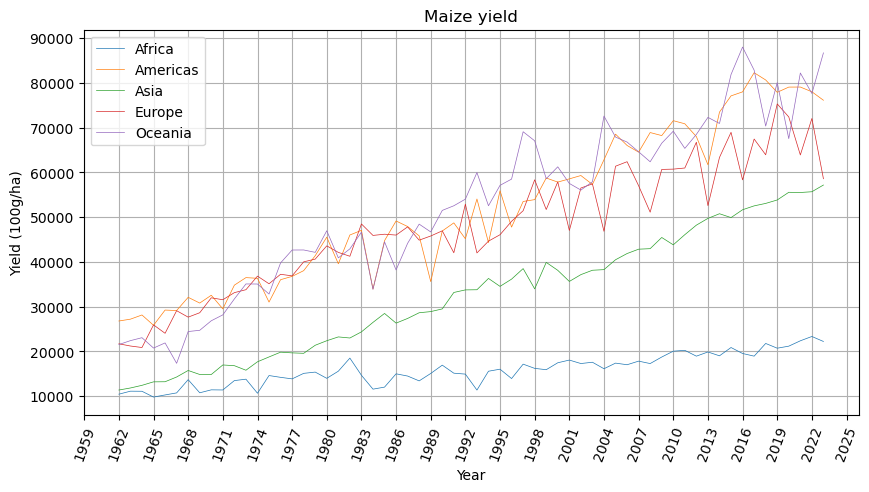

In [56]:
fig, ax = plt.subplots(figsize=(10,5))
ax.grid(True)
ax.set_title('Maize yield')
ax.set_xlabel('Year')
ax.set_ylabel('Yield (100g/ha)')
ax.set_xticks(year_index)
ax.set_xticklabels(year_index, rotation=70)
ax.xaxis.set_major_locator(dates.YearLocator(3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt_maize_africa = ax.plot(maize_yield_africa_tmp_df, linewidth=0.5, label='Africa')
plt_maize_americas = ax.plot(maize_yield_americas_tmp_df, linewidth=0.5, label='Americas')
plt_maize_asia = ax.plot(maize_yield_asia_tmp_df, linewidth=0.5, label='Asia')
plt_maize_europe = ax.plot(maize_yield_europe_tmp_df, linewidth=0.5, label='Europe')
plt_maize_oceania = ax.plot(maize_yield_oceania_tmp_df, linewidth=0.5, label='Oceania')
plt.legend(loc='upper left')

## Temperature change on land

In [65]:
path_temperature_dataset = 'data/FAOSTAT_Annual_temp_change_on_land_world_regions.csv'
temperature_tmp_df = pd.read_csv(path_temperature_dataset, usecols=['Area', 'Element', 'Months', 'Year', 'Value'])
temperature_tmp_df.shape

(10710, 5)

In [66]:
temperature_tmp_df.head(2)

,Area,Element,Months,Year,Value
0,Africa,Temperature change,January,1961,0.105
1,Africa,Temperature change,January,1962,-0.332


## Fertilizers by nutrient (synthetic fertilizers)
Nitrogen, phosphate P205, and potash.

In [11]:
path_fertilizers_dataset = 'data/FAOSTAT_synthetic_fertilizers_world_regions.csv'
fertilizers_tmp_df = pd.read_csv(path_fertilizers_dataset, usecols=['Area', 'Year', 'Value'])
fertilizers_tmp_df.shape

(915, 3)

In [13]:
fertilizers_tmp_df.tail(2)

,Area,Year,Value
913,Oceania,2020,435423.36
914,Oceania,2021,481150.46


## Livestock manure

In [15]:
path_manure_dataset = 'data/FAOSTAT_Livestock_manure_world_regions.csv'
manure_tmp_df = pd.read_csv(path_manure_dataset, usecols=['Area', 'Year', 'Value'])
manure_tmp_df.shape

(305, 3)

In [16]:
manure_tmp_df.tail(2)

,Area,Year,Value
303,Oceania,2020,2.317287e+08
304,Oceania,2021,2.412670e+08


## Precipitations
Data about precipitations at regional level can be retrieved from the [FAO Aquastat](https://www.fao.org/aquastat/en/) website.